In [19]:
"""
Assignment 1: Predictive model and deployment

Best Performed restaurant in Sydney

Jerry Tran - U3210410
"""
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy import stats
sns.set()
pd.set_option('display.max_columns', 60)


import warnings
warnings.filterwarnings("ignore")  
# Read the csv file
df = pd.read_csv('D:/1. MITS-UC/Sem 4/DS Technology and System/Assignment 1/data/data/zomato_df_final_data.csv')
df.head()
df.tail()  
df.describe()  
print('The  data has {0} rows and {1} columns'.format(df.shape[0],df.shape[1]))

The  data has 10500 rows and 17 columns


In [20]:
#Part A: Import and understand data
#1. Provide plot
# a. How many unique cuisines?
df['cuisine'].value_counts()
print('there are',df['cuisine'].nunique())

there are 1759


Top 3 suburb are:
 CBD            476
Surry Hills    260
Parramatta     225
Name: subzone, dtype: int64


Text(0.5, 1.0, 'Top 3 cities with highest numbers of restaurant ')

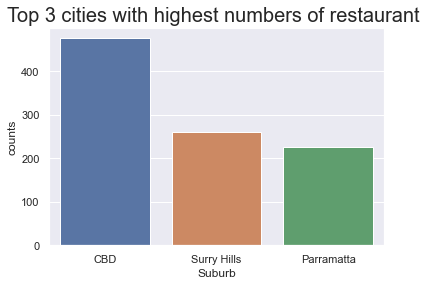

In [21]:
# b.Top 3 suburb has highest restaurant number'
print("Top 3 suburb are:\n", df['subzone'].value_counts()[0:3])
rest_count = df['subzone'].value_counts().rename_axis('Suburb').reset_index(name='counts')
rest_count = rest_count.sort_values(by = 'counts',ascending = False).head(3)
sns.barplot(rest_count['Suburb'],rest_count['counts'])
plt.title("Top 3 cities with highest numbers of restaurant ",fontsize = 20)



In [22]:
# c. excelent rate and expensive correlation: cost and rating_number

sns.set()
fig, ax = plt.subplots()
ax.plot(df['rating_number'], df['cost'], marker='o', linestyle='none')
ax.set_xlabel('rating_number',fontsize=12);
ax.set_ylabel('cost',fontsize=12);
plt.show()

""" 
There is not clear correlation between price and rating, there is only one clue that 
the more cheaper, the more people can afford and eat there 
and there are rare number of observations in the price more than 200.
"""


' \nThere is not clear correlation between price and rating, there is only one clue that \nthe more cheaper, the more people can afford and eat there \nand there are rare number of observations in the price more than 200.\n'

In [23]:
#2.Perform Exploratory analysis:

    #a. Cost distribution in the city:
df.head()
fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(df['cost'],ax=ax)
ax.set_title('Cost Distrubution for all restaurants')
"""
Most popular cost for restaurant meals are from 0 to 130.
"""


'\nMost popular cost for restaurant meals are from 0 to 130.\n'

In [24]:
#b. rating:
fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(df['rating_number'],ax=ax)
ax.set_title('Rating Distrubution for all restaurants')
"""
There are more rates from 3 to 3.5, there is no rate at 0 and 5.
"""


'\nThere are more rates from 3 to 3.5, there is no rate at 0 and 5.\n'

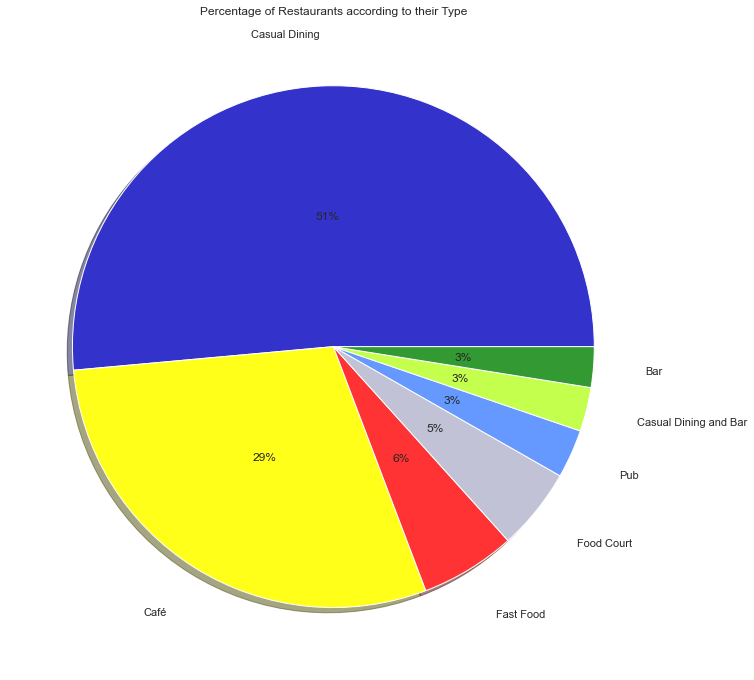

'\nCasual dining is at the most popular restaurant at 51%.\nThe second is cafe at 29%.\n'

In [25]:
#c. restaurant type:
restaurantTypeCount=df['type'].value_counts().sort_values(ascending=False)
slices=[restaurantTypeCount[0],
        restaurantTypeCount[1],
        restaurantTypeCount[2],
        restaurantTypeCount[3],
        restaurantTypeCount[4],
        restaurantTypeCount[5],
        restaurantTypeCount[6]]
labels=['Casual Dining','Café','Fast Food','Food Court','Pub','Casual Dining and Bar','Bar']
colors = ['#3333cc','#ffff1a','#ff3333','#c2c2d6','#6699ff','#c4ff4d','#339933']
plt.pie(slices,colors=colors, labels=labels, autopct='%1.0f%%', pctdistance=.5, labeldistance=1.2,shadow=True)
fig = plt.gcf()
plt.title("Percentage of Restaurants according to their Type")

fig.set_size_inches(12,12)
plt.show()
"""
Casual dining is at the most popular restaurant at 51%.
The second is cafe at 29%.
"""




In [26]:
#Part B: Predictive modelling
#I. Feature Engineering
#1. Impute missing value
"""
Delete Unnnecessary Columns (link, address)
Each restaurant has its own URL and address, so they are not valuable for predictive process
Delete the cost_2, cuisine color and color as they are not mentioned in the assignment
Delete the rating text as it's based on rating number
"""
d1=df.drop(['link', 'address','cost_2','cuisine_color','color','lat','lng'
            ,'phone','title','cuisine','subzone','type'],axis=1)



In [27]:
#Removing the Duplicates
d1.duplicated().sum()
d1.drop_duplicates(inplace=True)



In [28]:
#missing value
missings = pd.DataFrame(columns=['Columns','Missing','Percentage'])
for x in d1.columns:
    if d1[x].isna().sum() >0:
        missings = missings.append({'Columns': x ,'Missing': d1[x].isna().sum(), 
                                    'Percentage':(d1[x].isna().sum()/len(df[x])*100)}, ignore_index=True)
missings

# We have 4 variables missing: cost, rating_number,'rating_text', votes
# 3 numberic variables cost, rating_number, votes are imputed with mean
# Change missing value of rating_text with 'good' 

d1['rating_text'].fillna('Good',inplace=True)
d1['cost'].fillna(d1['cost'].mean,inplace=True)
d1['rating_number'].fillna(d1['rating_number'].mean,inplace=True)
d1['votes'].fillna(d1['votes'].mean)

0                                                     1311
1                                                     3236
2                                                     1227
3                                                      278
4                                                     2150
                               ...                        
9798     <bound method Series.mean of 0        1311.0\n...
9916     <bound method Series.mean of 0        1311.0\n...
10163    <bound method Series.mean of 0        1311.0\n...
10322    <bound method Series.mean of 0        1311.0\n...
10424    <bound method Series.mean of 0        1311.0\n...
Name: votes, Length: 5236, dtype: object

In [29]:
#Feature enocoding 'groupon' :bool (true or false) to number(1 or 0)
d1['groupon']=d1['groupon']*1
#Change cost and rating number to number
d1['cost'] =pd.to_numeric( d1['cost'], errors = 'coerce')
d1['rating_number'] =pd.to_numeric( d1['rating_number'], errors = 'coerce')

    

In [30]:
"""We use StandardScaler method to scale the continuous variables to the same type of categorical variables"""

from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
continuous_val = ['cost', 'rating_number', 'votes', 'groupon']
d1[continuous_val] = ssc.fit_transform(d1[continuous_val])

In [31]:
"""
We need to convert categorical variable into dummy variables and scale all the values before training the models. 
First, we use the get_dummies method to create dummy columns for categorical variables.
"""
categorical_val = ['rating_text']
d2= pd.get_dummies(d1, columns=categorical_val)

In [32]:
#Check dataframe
d2.head()
d2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5236 entries, 0 to 10424
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cost                   5154 non-null   float64
 1   rating_number          5177 non-null   float64
 2   votes                  5177 non-null   float64
 3   groupon                5236 non-null   float64
 4   rating_text_Average    5236 non-null   uint8  
 5   rating_text_Excellent  5236 non-null   uint8  
 6   rating_text_Good       5236 non-null   uint8  
 7   rating_text_Poor       5236 non-null   uint8  
 8   rating_text_Very Good  5236 non-null   uint8  
dtypes: float64(4), uint8(5)
memory usage: 230.1 KB


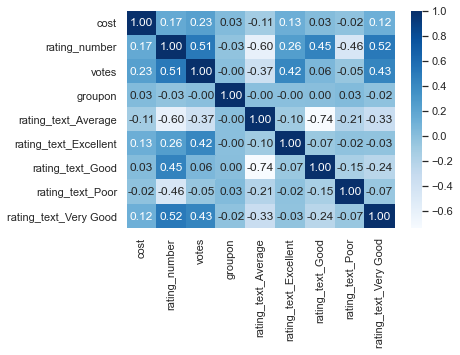

In [33]:
#Get Correlation between different variables
corr = d2.corr(method='kendall')
sns.heatmap(d2.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [34]:
""" II. Regression """
"""3.Model 1"""
""" We split the dataset into a training set and a test set with a test size of 0.2"""
d2 =d2[~d2.isin([np.nan, np.inf, -np.inf]).any(1)]
#Defining the independent variables and dependent variables
x = d2.drop('rating_number', axis=1)
y = d2['rating_number']

In [36]:
#Getting Test and Training Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 0)

X_train.fillna(X_train.mean())
y_train.fillna(y_train.mean())
from sklearn.linear_model import LinearRegression
lre = LinearRegression()

In [37]:
#train the train data
lre.fit(X_train, y_train)

LinearRegression()

In [38]:
#predict on the test data
pred = lre.predict(X_test)

In [39]:
#5.1 Evaluate the prediction for Module 1
from sklearn.metrics import mean_squared_error
print('Mean Squared Error:', mean_squared_error(y_test, pred))

Mean Squared Error: 0.17808388320894455


In [40]:
""" 4. Linear Regression 2:"""
x2=d2['votes']
y2=d2['rating_number']
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size= 0.2, random_state= 0)
plt.scatter(X_train, y_train)
plt.show()

In [41]:
# Building the model
m = 0
c = 0

L = 0.0001  # The learning Rate
epochs = 1000  # The number of iterations to perform gradient descent

n = float(len(X_train)) # Number of elements in X

# Performing Gradient Descent 
for i in range(epochs): 
    Y_pred = m*X_train + c  # The current predicted value of Y
    D_m = (-2/n) * sum(X_train * (y_train - Y_pred))  # Derivative wrt m
    D_c = (-2/n) * sum(y_train - Y_pred)  # Derivative wrt c
    m = m - L * D_m  # Update m
    c = c - L * D_c  # Update c
    
print (m, c)

0.09192837840921886 0.0005303062066940032


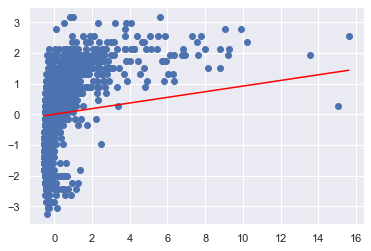

In [42]:
Y_pred = m*X_train + c

plt.scatter(X_train, y_train) 
plt.plot([min(X_train), max(X_train)], [min(Y_pred), max(Y_pred)], color='red')  # regression line
plt.show()

In [43]:
#predict on the test data
pred = m*X_test + c

In [44]:
#5.2. Evaluate the prediction
from sklearn.metrics import mean_squared_error
print('Mean Squared Error:', mean_squared_error(y_test, pred))

Mean Squared Error: 0.8709706345733239


In [45]:
"""
#III. Classification
"""

#6. Simplify data with 0 and 1
d3=d1.copy()
mapping = {'Good': 1, 'Very Good': 1, 'Excellent': 1,'Poor': 0,'Average':0}
d3=d3.replace({'rating_text': mapping})
d3.head()
d3.info()
d3['rating_text'].value_counts()

#The data is quite balanced

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5236 entries, 0 to 10424
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cost           5154 non-null   float64
 1   rating_number  5177 non-null   float64
 2   rating_text    5236 non-null   int64  
 3   votes          5177 non-null   float64
 4   groupon        5236 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 245.4 KB


0    2879
1    2357
Name: rating_text, dtype: int64

In [46]:
#7. Model 3: Build logistic regression model 
""" We split the dataset into a training set and a test set with a test size of 0.2"""

from sklearn.model_selection import train_test_split
d3 =d3[~d3.isin([np.nan, np.inf, -np.inf]).any(1)]
X3 = d3.drop('rating_text', axis=1)
y3 = d3['rating_text']

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
""" Logistic Regression"""

"""import the class"""
from sklearn.linear_model import LogisticRegression

"""instantiate the model (using the default parameters)"""
lr = LogisticRegression()

"""fit the model with the training data"""
lr.fit(X_train, y_train)

"""make a prediction for the test data"""
y_pred_1 = lr.predict(X_test)

In [47]:
""" Model Evaluation"""

"""import the metrics class"""
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

"""8. Confusion Matrix"""
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_1), annot= True, cmap='Reds')
plt.show()

In [48]:
"""Model evaluation metrics"""
print("Accuracy:", accuracy_score(y_test, y_pred_1))
print("Precision:", precision_score(y_test, y_pred_1, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_1, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_1, average='weighted'))
print("AUC-score:", roc_auc_score(y_test, y_pred_1))

lr_accuracy = accuracy_score(y_test, y_pred_1)
lr_f1 = f1_score(y_test, y_pred_1, average='weighted')
lr_auc = roc_auc_score(y_test, y_pred_1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
AUC-score: 1.0


In [49]:
"""Support Vector Machine"""

""" Building the model"""

"""import the class"""
from sklearn.svm import SVC

"""instantiate the model (using the default parameters)"""
svm = SVC()

"""fit the model with the training data"""
svm.fit(X_train, y_train)

"""make a prediction for the testing data"""
y_pred_2 = svm.predict(X_test)


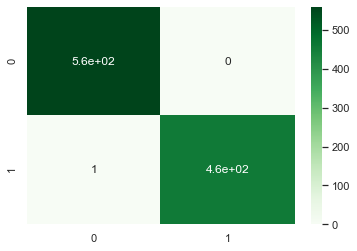

In [50]:
"""Model Evaluation"""

"""Confusion Matrix"""
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_2), annot=True, cmap='Greens')
plt.show()

In [51]:
"""Model evaluation metrics"""
print("Accuracy:", accuracy_score(y_test, y_pred_2))
print("Precision:", precision_score(y_test, y_pred_2, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_2, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_2, average='weighted'))
print("AUC-score:", roc_auc_score(y_test, y_pred_2))
svm_accuracy = accuracy_score(y_test, y_pred_2)
svm_f1 = f1_score(y_test, y_pred_2, average='weighted')
svm_auc = roc_auc_score(y_test, y_pred_2)

Accuracy: 0.9990196078431373
Precision: 0.9990213554227395
Recall: 0.9990196078431373
F1-score: 0.9990195117261659
AUC-score: 0.9989130434782609


In [52]:
"""Random Forest"""

"""Building the model"""

"""import the class"""
from sklearn.ensemble import RandomForestClassifier

"""instantiate the model (using the default parameters)"""
rf = RandomForestClassifier()

"""fit the model with the training data"""
rf.fit(X_train, y_train)

"""Make a prediction for the testing data"""
y_pred_3 = rf.predict(X_test)

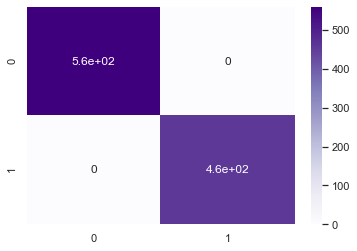

In [53]:
"""Confusion Matrix"""
fig = plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_3), annot=True, cmap='Purples')
plt.show()

In [54]:
"""Model evaluation metrics"""
print("Accuracy:", accuracy_score(y_test, y_pred_3))
print("Precision:", precision_score(y_test, y_pred_3, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_3, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_3, average='weighted'))
print("AUC-score:", roc_auc_score(y_test, y_pred_3))

rf_accuracy = accuracy_score(y_test, y_pred_3)
rf_f1 = f1_score(y_test, y_pred_3, average='weighted')
rf_auc = roc_auc_score(y_test, y_pred_3)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
AUC-score: 1.0


In [55]:
"""9. Draw conclusion"""

"""Model accuracy plot"""
model_accuracy = pd.Series(data=[lr_accuracy, svm_accuracy, rf_accuracy],
                           index=['Logistic Regression', 'Support Vector Machine', 'Random Forest'])
fig = plt.figure(figsize=(8, 8))
model_accuracy.sort_values().plot.barh()
plt.title('Model Accuracy')
plt.show()

In [56]:
"""Model f1_score plot"""
model_f1_score = pd.Series(data=[lr_f1, svm_f1, rf_f1],
                           index=['Logistic Regression', 'Support Vector Machine', 'Random Forest'])
fig = plt.figure(figsize=(8, 8))
model_f1_score.sort_values().plot.barh()
plt.title('Model F1 Score Comparison')
plt.show()

In [57]:
"""Model auc_score plot"""
model_auc_score = pd.Series(data=[lr_auc, svm_auc, rf_auc],
                           index=['Logistic Regression', 'Support Vector Machine', 'Random Forest'])
fig = plt.figure(figsize=(8, 8))
model_auc_score.sort_values().plot.barh()
plt.title('Model AUC Score Comparison')
plt.show()

In [58]:
"""Feature importance for random forest model"""
fig = plt.figure(figsize=(10, 10))
important = pd.Series(rf.feature_importances_, index=X_train.columns)
sns.set_style('whitegrid')
important.sort_values().plot.barh()
plt.title('Feature Importance')
plt.show()